# 90 · Generative Synthesis
        
        Train a lightweight VAE on tabular features to synthesize anomalies/augment data.
        - Load numeric fraud features (processed parquet).
        - Inspect feature stats.
        - Fit the VAE and plot training loss.


In [ ]:
# Helper: clean DataFrame to avoid missing-column/NaN errors
import pandas as pd

def clean_frame(df, target=None, numeric_expected=None, categorical_expected=None):
    df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
    df = df.dropna(axis=1, how='all').copy()
    numeric_expected = numeric_expected or []
    categorical_expected = categorical_expected or []
    for col in numeric_expected:
        if col not in df.columns:
            df[col] = 0.0
    for col in categorical_expected:
        if col not in df.columns:
            df[col] = 'missing'
    num_cols = df.select_dtypes(include=['number']).columns
    cat_cols = df.select_dtypes(exclude=['number']).columns
    if len(num_cols):
        df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    if len(cat_cols):
        df[cat_cols] = df[cat_cols].fillna('missing')
    if target:
        if target not in df.columns:
            raise KeyError(f"Target '{target}' missing. Columns: {df.columns.tolist()}")
        df[target] = pd.to_numeric(df[target], errors='coerce').fillna(0).astype(int)
    return df


In [1]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt

project_root = Path('..').resolve()
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from uais.generative.train_vae import VAEConfig, run_vae_pipeline


In [2]:
# Load numeric features
dataset_path = project_root / 'data' / 'processed' / 'fraud' / 'fraud_features.parquet'
if not dataset_path.exists():
    dataset_path = project_root / 'data' / 'raw' / 'fraud' / 'creditcard.csv'
if not dataset_path.exists():
    raise FileNotFoundError(f'Missing dataset for VAE: {dataset_path}')
df = pd.read_parquet(dataset_path) if dataset_path.suffix == '.parquet' else pd.read_csv(dataset_path)
num_df = df.select_dtypes(include=['number']).dropna()
print('Using dataset:', dataset_path)
print('Rows:', len(num_df), 'Cols:', num_df.shape[1])
print(num_df.describe().head())


Using dataset: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/data/processed/fraud/fraud_features.parquet
Rows: 284807 Cols: 35
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.175161e-15  3.384974e-16 -1.379537e-15  2.094852e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.021879e-15  1.494498e-15 -5.620335e-16  1.149614e-16 -2.414189e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.32167

In [ ]:
df = clean_frame(df)
print('After cleaning:', df.shape)


Recon error mean/std: 0.3643234074115753 0.3843595087528229


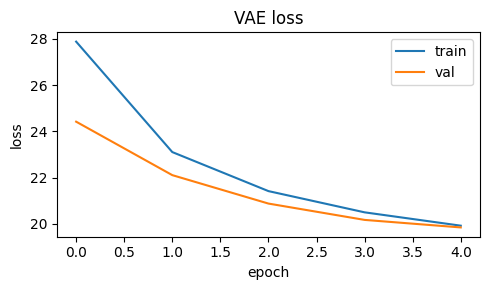

Saved loss plot to /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/experiments/generative/vae_loss.png


In [3]:
config = VAEConfig(dataset_path=dataset_path, latent_dim=8, epochs=5, batch_size=256)
metrics = run_vae_pipeline(config)

print('Recon error mean/std:', metrics['reconstruction_error_mean'], metrics['reconstruction_error_std'])
hist = metrics.get('history', {})
plots_dir = project_root / 'experiments' / 'generative'
plots_dir.mkdir(parents=True, exist_ok=True)
plot_path = plots_dir / 'vae_loss.png'
if hist:
    plt.figure(figsize=(5,3))
    plt.plot(hist.get('loss', []), label='train')
    plt.plot(hist.get('val_loss', []), label='val')
    plt.legend(); plt.title('VAE loss'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.tight_layout()
    plt.savefig(plot_path, dpi=150)
    plt.show()
    plt.close()
    print('Saved loss plot to', plot_path)
else:
    print('No training history to plot')
